In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix
import os
import random
import gc

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)

In [3]:
# Define the Attention Layer
class Attention(nn.Module):
    def __init__(self, shape):
        super(Attention, self).__init__()
        self.attention_dense = nn.Linear(shape, shape)
    
    def forward(self, inputs):
        # Apply linear transformation
        a = self.attention_dense(inputs)
        # Apply softmax to get attention scores
        attention_scores = torch.softmax(a, dim=-1)
        # Element-wise multiplication with inputs
        output_attention_mul = inputs * attention_scores
        return output_attention_mul, attention_scores

# Define the Model
class CustomModel_attext(nn.Module):
    def __init__(self, n_wind, n_features, dense_nparams1=256, n_classes=15):  # n_classes is added
        super(CustomModel_attext, self).__init__()
        self.attention = Attention(n_features)
        self.lstm = nn.LSTM(n_features, dense_nparams1, num_layers=1, batch_first=True)
        self.dense = nn.Linear(dense_nparams1, n_classes)  # Output layer now has n_classes outputs
    
    def forward(self, x, return_attention=False):
        # Get the attended output and attention scores
        x, attention_scores = self.attention(x)
        # Pass through LSTM
        x, _ = self.lstm(x)
        # Extract the last output of the LSTM
        x = x[:, -1, :]
        # Apply the dense layer to get logits (no softmax)
        logits = self.dense(x)
        
        if return_attention:
            return logits, attention_scores
        return logits

## load test data

In [4]:
dtest = torch.load('Phenotyping/Ptest.pt')
ytest = torch.load('Phenotyping/y_test.pt')

In [5]:
dtest.shape, ytest.shape

(torch.Size([2217, 288, 231]), torch.Size([2217]))

### find ytest_distribution

In [6]:
ytestnp = ytest.numpy()

In [7]:
text_labels = ['Cardiovascular', 'Respiratory', 'Gastrointestinal', 'Neurological', 'Other Medical Disease', 'Trauma not surgical',
               'Metabolic/Endocrinology', 'Hematologic', 'Cardiovascular Surgical', 'Respiratory Surgical', 'Gastrointestinal Surgical',
               'Neurological Surgical', 'Trauma Surgical', 'Renal Surgical', 'Other Surgical']

In [8]:
# Get the unique labels and their counts
unique_labels, counts = np.unique(ytestnp, return_counts=True)

# If you want the percentage distribution
total = ytestnp.shape[0]


# Display the distribution
for label, count in zip(unique_labels, counts):
    percentage_distribution = (count / total) * 100
    # print(f"Label {label}: {count} occurrences Label {label}: {percentage_distribution:.2f}%")
    print(f"Label {label}: {count} {text_labels[int(label)]} ")


Label 0.0: 355 Cardiovascular 
Label 1.0: 260 Respiratory 
Label 2.0: 130 Gastrointestinal 
Label 3.0: 503 Neurological 
Label 4.0: 121 Other Medical Disease 
Label 5.0: 162 Trauma not surgical 
Label 6.0: 44 Metabolic/Endocrinology 
Label 7.0: 6 Hematologic 
Label 8.0: 297 Cardiovascular Surgical 
Label 9.0: 31 Respiratory Surgical 
Label 10.0: 105 Gastrointestinal Surgical 
Label 11.0: 154 Neurological Surgical 
Label 12.0: 20 Trauma Surgical 
Label 13.0: 2 Renal Surgical 
Label 14.0: 27 Other Surgical 


In [9]:
## cardio Indices
cardio_indices = np.where(ytestnp == 0)[0]
resp_indices = np.where(ytestnp == 1)[0]
gastro_indices = np.where(ytestnp == 2)[0]
neuro_indices = np.where(ytestnp == 3)[0]

In [10]:
cardio_indices.shape, resp_indices.shape, gastro_indices.shape, neuro_indices.shape

((355,), (260,), (130,), (503,))

In [174]:
# model = CustomModel(288, 231)
model = CustomModel_attext(288, 231, 15)

## load weights

In [175]:
# model.load_state_dict(torch.load("model_checkpoints/phenotyping/models/bm_bal_acc_seed_000.pth"))
model.load_state_dict(torch.load("model_checkpoints/phenotyping/models/bm_bal_acc_seed_001.pth"))
model.eval()  # Set the model to evaluation mode

CustomModel_attext(
  (attention): Attention(
    (attention_dense): Linear(in_features=231, out_features=231, bias=True)
  )
  (lstm): LSTM(231, 15, batch_first=True)
  (dense): Linear(in_features=15, out_features=15, bias=True)
)

### predict on loaded model

In [176]:
model = model.cuda(0)

In [177]:
dtest4 = dtest.numpy()[7]

In [178]:
# Run the model and make a prediction with attention scores
dtest4_tensor = torch.tensor(dtest4).unsqueeze(0).cuda(0)

In [179]:
import torch.nn.functional as F

with torch.no_grad():
    # Perform the forward pass with the model to get predictions and attention scores
    pred4, attention_scores = model(dtest4_tensor, return_attention=True)

    # Apply softmax to convert logits to probabilities
    probabilities = F.softmax(pred4, dim=1).cpu().numpy()  # Convert to numpy array if needed

    # Get the predicted class by finding the index with the highest probability for each sample
    pred4_class = np.argmax(probabilities, axis=1)  # Convert to numpy array if needed
    
    probabilities  = probabilities.flatten()

    # If you need attention scores, process them as well
    attention_scores = attention_scores.squeeze().detach().cpu().numpy()

In [180]:
cprob = probabilities[0]

In [181]:
cprob, pred4_class, attention_scores.shape

(0.9493867, array([0]), (288, 231))

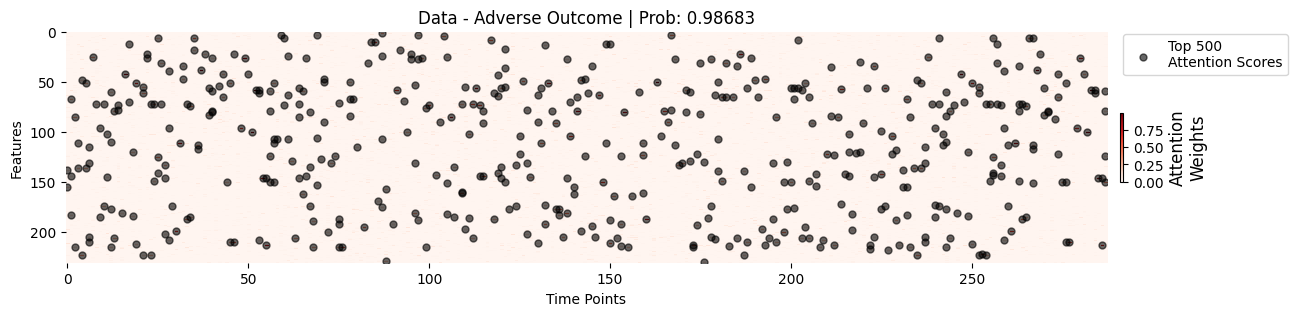

In [173]:
att_scores = attention_scores
fig, ax = plt.subplots(1, 1, figsize=(16, 3))

# Define the number of top values to highlight
num_top_values = 500 #500

# Find the indices of the top N values
flat_indices = np.argsort(att_scores.T, axis=None)[-num_top_values:]
top_indices = np.unravel_index(flat_indices, att_scores.T.shape)

im = plt.imshow(att_scores.T, cmap='Reds', aspect='auto', interpolation='nearest')
plt.title(f'Data - Adverse Outcome | Prob: {cprob:.5f}')
plt.xlabel("Time Points")
plt.ylabel("Features")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
fig.colorbar(im, ax=ax, 
             location = 'right',
             orientation='vertical',
             # fraction=0.9,
             # aspect=2,
             pad=0.01,
             # bbox_to_anchor=(0.1,0,1,1),
             shrink=0.3,
             # anchor=(0.5, 0.5),
            ).set_label('Attention\nWeights', fontsize=12)

plt.scatter(top_indices[1], top_indices[0], color='k', marker='.', s=100, label=f'Top {num_top_values}\nAttention Scores',alpha=0.6)
ax.legend(bbox_to_anchor=(1.18, 1.02))
plt.show()

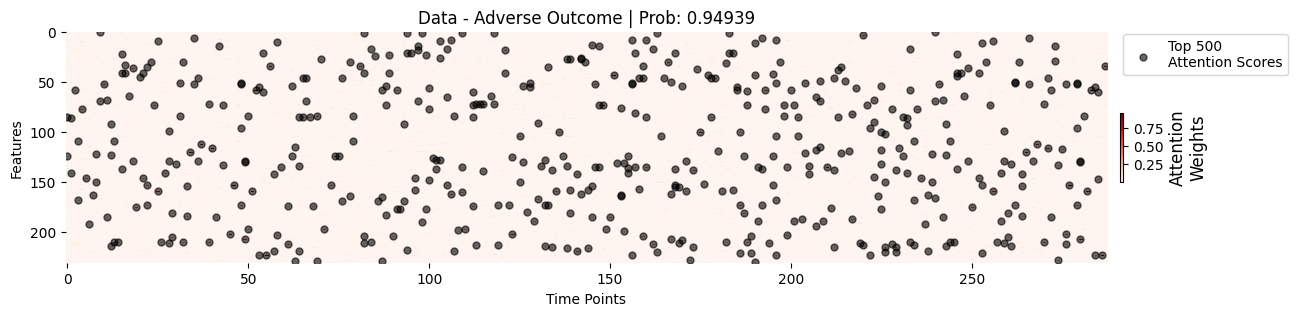

In [182]:
att_scores = attention_scores
fig, ax = plt.subplots(1, 1, figsize=(16, 3))

# Define the number of top values to highlight
num_top_values = 500 #500

# Find the indices of the top N values
flat_indices_2 = np.argsort(att_scores.T, axis=None)[-num_top_values:]
top_indices_2 = np.unravel_index(flat_indices_2, att_scores.T.shape)

im = plt.imshow(att_scores.T, cmap='Reds', aspect='auto', interpolation='nearest')
plt.title(f'Data - Adverse Outcome | Prob: {cprob:.5f}')
plt.xlabel("Time Points")
plt.ylabel("Features")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
fig.colorbar(im, ax=ax, 
             location = 'right',
             orientation='vertical',
             # fraction=0.9,
             # aspect=2,
             pad=0.01,
             # bbox_to_anchor=(0.1,0,1,1),
             shrink=0.3,
             # anchor=(0.5, 0.5),
            ).set_label('Attention\nWeights', fontsize=12)

plt.scatter(top_indices_2[1], top_indices_2[0], color='k', marker='.', s=100, label=f'Top {num_top_values}\nAttention Scores',alpha=0.6)
ax.legend(bbox_to_anchor=(1.18, 1.02))
plt.show()

In [13]:
modeldir = sorted(os.listdir('model_checkpoints/phenotyping/models'))

In [14]:
len(modeldir)

1000

In [275]:
# modeldir[:10]

In [147]:
dtest4 = dtest.numpy()[7]

In [149]:
dtest4.shape

(288, 231)

### attention drop cumulative

In [20]:
def cudrop(num_model, topk, pid):

    pred_list = []
    topk_list = []
    
    indices = list(range(num_model))

    # Shuffle the list in place
    random.shuffle(indices)
    
    for i in indices:
        modelfile = modeldir[i]
        model = CustomModel_attext(288,231,15)
        model.load_state_dict(torch.load(f'model_checkpoints/phenotyping/models/{modelfile}'))
        model.eval()  # Set the model to evaluation mode
        model = model.cuda(0)
        dtestp = dtest.numpy()[pid]
        dtestp_tensor = torch.tensor(dtestp).unsqueeze(0).cuda(0)
        with torch.no_grad():
            predp, attention_scores = model(dtestp_tensor, return_attention=True)
            probabilities = F.softmax(predp, dim=1).cpu().numpy()  # Convert to numpy array if needed
            predp_class = np.argmax(probabilities, axis=1)  # Convert to numpy array if needed
            probabilities  = probabilities.flatten()[0]
            att_scores = attention_scores.squeeze().detach().cpu().numpy()

        pred_list.append(round(probabilities,4))

        # Define the number of top values to highlight
        num_top_values = topk #500

        # Find the indices of the top N values
        flat_indices = np.argsort(att_scores.T, axis=None)[-num_top_values:]
        top_indices = np.unravel_index(flat_indices, att_scores.T.shape)

        topk_list.append(top_indices)
        
        
    running_means = []
    running_sum = 0

    # Calculate running mean for each value in the values list
    for i, value in enumerate(pred_list):
        running_sum += value
        running_mean = running_sum / (i + 1)
        running_means.append(round(running_mean, 4))  # Restrict to 4 decimal places
        
        
    cumulative_matrix = np.ones((231, 288), dtype=int)  # Ensure correct matrix size
    cl_list = []
    # Iterate through each set of top_indices tuples (10 runs)
    for i, top_indices in enumerate(topk_list):
        # Initialize a 2D matrix with zeros for the current run
        matrix = np.zeros((231, 288), dtype=int)  # Ensure correct matrix size

        # Fill the matrix with 1s at the positions specified by the coordinates
        for y, x in zip(top_indices[0], top_indices[1]):
            matrix[y, x] = 1

        # Perform an element-wise logical AND with the cumulative matrix
        cumulative_matrix = np.logical_and(cumulative_matrix, matrix)

        cl_list.append(np.sum(cumulative_matrix))
        
        
    return cl_list, list(range(len(cl_list))), pred_list, running_means

# for all patients

In [15]:
import pickle

In [34]:
# adverse_list = cardio_indices.tolist()
# adverse_list = gastro_indices.tolist()
# adverse_list = resp_indices.tolist()
adverse_list = neuro_indices.tolist()

In [35]:
list100  = []
list1000 = []
list10000= []

for i in tqdm(adverse_list):
    list100.append(cudrop(1000, 100, i))
    list1000.append(cudrop(1000, 1000, i))
    list10000.append(cudrop(1000, 10000, i))

  0%|          | 0/503 [00:00<?, ?it/s]

In [36]:
import pickle

In [38]:
list1k = list1000
list10k = list10000

In [39]:
len(list100), len(list1k), len(list10k)

(503, 503, 503)

In [40]:
# Save the list to a pickle file
with open('pheno_neuro_cudrop_1000m_100f.pkl', 'wb') as file:  # Open file in binary write mode
    pickle.dump(list100, file)
    
# Save the list to a pickle file
with open('pheno_neuro_cudrop_1000m_1000f.pkl', 'wb') as file:  # Open file in binary write mode
    pickle.dump(list1k, file)
    
# Save the list to a pickle file
with open('pheno_neuro_cudrop_1000m_10000f.pkl', 'wb') as file:  # Open file in binary write mode
    pickle.dump(list10k, file)

In [41]:
list100_mean     = np.mean(np.array([item[0] for item  in list100]),axis=0).tolist()
list1k_mean      = np.mean(np.array([item[0] for item  in list1k]),axis=0).tolist()
list10k_mean     = np.mean(np.array([item[0] for item  in list10k]),axis=0).tolist()

In [42]:
len(list100_mean), len(list1k_mean), len(list10k_mean)

(1000, 1000, 1000)

In [ ]:
# Create the scatter plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6)) # Set figure size for better clarity
###################################################################################################### for 10000 top features


for item in list100:
    plt.scatter(item[1], item[0], color='#d62728', marker='o', s=1, alpha=0.005)
    plt.plot(item[1], item[0], color='#d62728',alpha=0.1)
    

for item in list1k:
    plt.scatter(item[1], item[0], color='#1f77b4', marker='o', s=1, alpha=0.005)
    plt.plot(item[1], item[0], color='#1f77b4',alpha=0.1)
    
    
for item in list10k:
    plt.scatter(item[1], item[0], color='#2ca02c', marker='o', s=1, alpha=0.005)
    plt.plot(item[1], item[0], color='#2ca02c',alpha=0.1)    

############################################################################################### 

plt.scatter(list(range(len(list100_mean))), list100_mean, color='#a31c1c', marker='.', s=2, alpha=1.0)
plt.plot(list(range(len(list100_mean))), list100_mean, color='#a31c1c',alpha=1.0, label='100')

plt.scatter(list(range(len(list1k_mean))), list1k_mean, color='#154c7a', marker='.', s=2, alpha=1.0)
plt.plot(list(range(len(list1k_mean))), list1k_mean, color='#154c7a',alpha=1.0, label='1000')

plt.scatter(list(range(len(list10k_mean))), list10k_mean, color='#217821', marker='.', s=2, alpha=1.0)
plt.plot( list(range(len(list10k_mean))), list10k_mean, color='#217821',alpha=1.0,label='10000')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Add labels and title with enhanced font size
plt.xlabel('Cumulative Model Runs', fontsize=12)
plt.ylabel('Common Top Attention Scores across model runs', fontsize=12)
plt.title('Common Top Attention Scores per cumulative model runs | Respiratory', fontsize=12, 
          # weight='bold'
         )

# Enhance ticks for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.yscale('symlog', 
           linthresh=10
          )
# plt.yscale('asinh', linthresh=10)
plt.xscale('symlog', 
           # linthresh=10
          )
# plt.xscale('asinh')

plt.ylim(0,20000)
plt.xlim(0,101)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Display the plot
# Reversing the order of the legend items
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper right', fontsize=16, title='Top Attention Scores at start')  # Reversing handles and labels

plt.tight_layout()  # Adjust layout to make sure everything fits nicely
plt.show()